### Credits & Content
**Author:** Bastien Hottelet

**Date:** 10/03/2024

**Content:**

* Environment Setup
* Definition of model related functions
* Loading and configuration of the model
* Dataset importation and Fine tuning
  + SQuAD
  + QuAC
  + PubMedQA
  + BioASQ - Task B
  + MedQuAD 
* Saving the model to Google Drive
* Loading the model from Google Drive

# Environment Setup

Installation of all the required dependencies


In [1]:
%pip install keras-nlp
%pip install pandas # To handle the datasets
%pip install -q --upgrade keras  # Upgrade to Keras 3.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing all the required dependencies and enabling mixed precision to make the training faster.

Set the Keras Backend to Tensorflow as asked in the requirements of the project (could have used "jax" or "torch" otherwise).

In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import time
import keras
import keras_nlp
import pandas as pd
import tensorflow as tf

keras.mixed_precision.set_global_policy("mixed_float16")

Definition of some useful hyperparameter that will make the code editing easier. (Only EPOCHS and BATCH_SIZE might be edited after depending the next training dataset's complexity)

In [4]:
# General hyperparameters
EPOCHS = 8
BATCH_SIZE = 32

GPT2_PRESET = "gpt2_large_en"

# LoRA-specific hyperparameters
RANK = 4
ALPHA = 32.0

# Model Related Functions
All functions related to the model and the operations done with it.


Cleaning of the answer, removal of the original prompt engineering and cut at the end of the last finished sentence in the answer.

In [5]:
def clean_answer_text(text: str) -> str:
    # Define the start marker for the model's response
    response_start = text.find("[ANSWER]") + len("[ANSWER]")

    # Extract everything after "Doctor:"
    response_text = text[response_start:].strip()
    last_dot_index = response_text.rfind(".")
    if last_dot_index != -1:
      response_text = response_text[:last_dot_index + 1]

    # Additional cleaning if necessary (e.g., removing leading/trailing spaces or new lines)
    response_text = response_text.strip()

    return response_text


Function to generate a text from a prompt using the model and the two functions defined previously to clean our answer.
Also include some prompt engineering to improve the answer quality that we will get from our model. Attempt to turn the text generation nature of the model into a question answering model.

In [6]:
def generate_responses(model, question):
    prompt = f"[QUESTION] {question} [ANSWER]"
    output = model.generate(prompt, max_length=1024)
    # Clean and extract the model's response from `output`
    return clean_answer_text(output)

Function creating the optimizer and loss objects needed in our LoRA model.

Optimizer is AdamW and loss is SparseCategoricalCrossentropy, those are both the default choice for language modeling tasks, they tend to be effective and generally more efficient than others so we will stick to them.

In [7]:
def get_optimizer_and_loss():
    optimizer = keras.optimizers.AdamW(
        learning_rate=5e-5,
        weight_decay=0.01,
        epsilon=1e-6,
        global_clipnorm=1.0,  # Gradient clipping.
    )
    # Exclude layernorm and bias terms from weight decay.
    optimizer.exclude_from_weight_decay(var_names=["bias"])
    optimizer.exclude_from_weight_decay(var_names=["gamma"])
    optimizer.exclude_from_weight_decay(var_names=["beta"])

    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return optimizer, loss

Function to list all the layers of a given model

In [8]:
def list_all_layers(model, prefix="", level=0):
    for i, layer in enumerate(model.layers):
        # Construct a new prefix for the current layer
        layer_info = f"{prefix}Layer {i}: {layer.name} (Type: {type(layer).__name__}, Trainable: {layer.trainable})"
        print("  " * level + layer_info)

        # Check for nested Keras models
        if hasattr(layer, 'layers'):
            list_all_layers(layer, prefix=prefix, level=level+1)

        # Specific handling to reach deeper into TransformerDecoder or similar custom layers
        if hasattr(layer, '_self_attention_layer'):
            self_attention = layer._self_attention_layer
            print_self_attention_details(self_attention, level=level+2)

Function to list all the details about a self_attention layer, useful when checking our model after reverting our LoRA changes

In [9]:
def print_self_attention_details(self_attention_layer, level=0):
    for attr in ['_query_dense', '_key_dense', '_value_dense', '_output_dense']:
        if hasattr(self_attention_layer, attr):
            layer = getattr(self_attention_layer, attr)
            if layer:
                print("  " * level + f"{attr}: (Type: {type(layer).__name__}, Trainable: {layer.trainable})")
                if hasattr(layer, 'layers'):  # In case your custom layer contains sublayers
                    list_all_layers(layer, level=level+1)

## LoRA (Low Rank Adaptation)
In this notebook, we will use Keras LoRA implementation.
LoRA is a training technique used for large language models (LLM) to train them more efficiently and with a less time consuming approach.
How it works is the following:
- Look at the pretrained model's weights
- Determine the linearly independent and dependent columns of the matrix
- Create the new LoRA layer with only the linearly independant matrix columns
- Freeze the pretrained's model weights
- Train the LoRA layer weights
- Merge the weights of the pretrained model and the LoRA layer

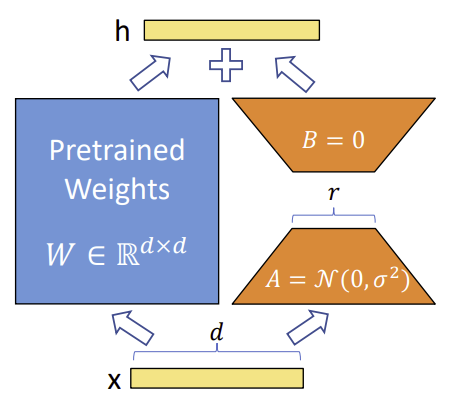

Implementation of our LoRA layer.

In [10]:
import math

class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=32,
        trainable=False,
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer.
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = original_layer_config["output_shape"][-2]
        self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        # No matter whether we are training the model or are in inference mode,
        # this layer should be frozen.
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=trainable,
            name=f"lora_A",
        )
        # B has the same `equation` and `output_shape` as the original layer.
        # `equation = abc,cde->abde`, where `a`: batch size, `b`: sequence
        # length, `c`: `hidden_dim`, `d`: `num_heads`,
        # `e`: `hidden_dim//num_heads`. The only difference is that in layer `B`,
        # `c` represents `rank`.
        self.B = keras.layers.EinsumDense(
            equation=original_layer_config["equation"],
            output_shape=original_layer_config["output_shape"],
            kernel_initializer="zeros",
            trainable=trainable,
            name=f"lora_B",
        )

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        # If we are in inference mode, we "merge" the LoRA layers' weights into
        # the original layer's weights - more on this in the text generation
        # section!
        return original_output

# Load and configure the Model
Load the original/basic model and preprocessor for GPT-2

In [11]:
# Load the original model.
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    GPT2_PRESET,
    sequence_length=128,
)
lora_model = keras_nlp.models.GPT2CausalLM.from_preset(
    GPT2_PRESET,
    preprocessor=preprocessor,
)

100%|██████████| 448/448 [00:00<00:00, 493kB/s]
100%|██████████| 446k/446k [00:00<00:00, 1.40MB/s]
100%|██████████| 0.99M/0.99M [00:00<00:00, 2.66MB/s]
100%|██████████| 485/485 [00:00<00:00, 833kB/s]
100%|██████████| 2.88G/2.88G [00:56<00:00, 54.6MB/s]


Check the original model architecture.

In [12]:
list_all_layers(lora_model)

Layer 0: padding_mask (Type: InputLayer, Trainable: True)
Layer 1: token_ids (Type: InputLayer, Trainable: True)
Layer 2: gpt2_backbone (Type: GPT2Backbone, Trainable: True)
  Layer 0: token_ids (Type: InputLayer, Trainable: True)
  Layer 1: token_embedding (Type: ReversibleEmbedding, Trainable: True)
  Layer 2: position_embedding (Type: PositionEmbedding, Trainable: True)
  Layer 3: embeddings_add (Type: Add, Trainable: True)
  Layer 4: embeddings_dropout (Type: Dropout, Trainable: True)
  Layer 5: padding_mask (Type: InputLayer, Trainable: True)
  Layer 6: transformer_layer_0 (Type: TransformerDecoder, Trainable: True)
      _query_dense: (Type: EinsumDense, Trainable: True)
      _key_dense: (Type: EinsumDense, Trainable: True)
      _value_dense: (Type: EinsumDense, Trainable: True)
      _output_dense: (Type: EinsumDense, Trainable: True)
  Layer 7: transformer_layer_1 (Type: TransformerDecoder, Trainable: True)
      _query_dense: (Type: EinsumDense, Trainable: True)
      _key_d

Override the original query/value projection matrices with the new LoRA layers.


In [13]:
for layer_idx in range(lora_model.backbone.num_layers):
    # Change query dense layer.
    decoder_layer = lora_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer
    # Allow mutation to Keras layer state.
    self_attention_layer._tracker.locked = False

    # Change query dense layer.
    self_attention_layer._query_dense = LoraLayer(
        self_attention_layer._query_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

    # Change value dense layer.
    self_attention_layer._value_dense = LoraLayer(
        self_attention_layer._value_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

Make sure the chain of computation is still correct.

In [14]:
lora_model(preprocessor(["LoRA is very useful for quick LLM finetuning"])[0])
pass

Freeze the pretrained model so only the LoRA layers will be trained.

In [15]:
for layer in lora_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())

    if len(lst_of_sublayers) == 1:  # "leaves of the model"
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

In [16]:
lora_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                     │                                              50,257 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gpt2_backbone (GPT2Backbone)  │ (None, None, 1280)        │     774,767,360 │ padding_mask[0][0],        │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │      64,328,960 │ gpt2_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 774,767,360 (2.89 GB)

 Trainable params: 737,280 (2.81 MB)

 Non-trainable params: 774,030,080 (2.88 GB)

# Fine Tuning of the Model

In this training sequence, we aim to develop a model capable of understanding and generating answers for healthcare-related questions. The logic behind the chosen sequence is to gradually transition the model from general language understanding to specialized healthcare knowledge.

The datasets we will use are:
- SQuAD
- QuAC
- BioASQ (Task A & B)
- MedQuAD
- PubMedQA

In this code we define the file path that will be used for each dataset throughout the training.

In [17]:
SQUAD_FILEPATH = "/content/drive/MyDrive/Medical_Chatbot_GPT2/Datasets/SQuAD/data.json"
QUAC_FILEPATH = "/content/drive/MyDrive/Medical_Chatbot_GPT2/Datasets/QuAC/data.json"
PUBMEDQA_FILEPATH = "/content/drive/MyDrive/Medical_Chatbot_GPT2/Datasets/PubMedQA/data.json"
BIOASQ_B_FILEPATH = "/content/drive/MyDrive/Medical_Chatbot_GPT2/Datasets/BioASQ-training12b/data.json"
MEDQUAD_FILEPATH = "/content/drive/MyDrive/Medical_Chatbot_GPT2/Datasets/MedQuAD/data.csv"

Get optimizer and loss functions from the previously written function.

In [18]:
optimizer, loss = get_optimizer_and_loss()

Perplexity is one of the most common metrics for evaluating language models during training. It measures how well a probability distribution or probability model predicts a sample. A lower perplexity score indicates that the model is better at predicting the sample.

That's why we will create our own implementation of perplexity in this notebook and then compile our model with this custom metric and the optimizer and loss function retrieved earlier.


In [19]:
import tensorflow as tf
from tensorflow.keras import backend as K

def perplexity_metric(y_true, y_pred):
    cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    perplexity = K.exp(cross_entropy)
    return K.mean(perplexity)

In [20]:
lora_model.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=[perplexity_metric])

## 1 - Starting with SQuAD

Provides a solid foundation in general language comprehension and answer generation across a wide range of topics, essential for the initial stages of model training.

Link to the dataset: https://rajpurkar.github.io/SQuAD-explorer/

In [21]:
import json

# Load the SQuAD dataset
with open(SQUAD_FILEPATH) as f:
    squad_data = json.load(f)

# Prepare lists for inputs and targets
squad_formatted_data = []

for article in squad_data['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            # Assuming the first answer is used for simplicity, and checking if answers are available
            answer = qa['answers'][0]['text'] if qa['answers'] else 'No Answer Found'

            # Format the input text by concatenating question and context
            input_text = f"[QUESTION] {question} [CONTEXT] {context} [ANSWER] {answer}"

            squad_formatted_data.append(input_text)

del squad_data


In [22]:
len(squad_formatted_data)

130319

In [23]:
# Make sure we have the correct parameters according to the dataset's complexity
EPOCHS = 2
BATCH_SIZE = 16

In [24]:
# Train the model
lora_model.fit(squad_formatted_data,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE)

Epoch 1/2
16290/16290 ━━━━━━━━━━━━━━━━━━━━ 2716s 147ms/step - loss: 2.5936 - perplexity_metric: 158391120.0000
Epoch 2/2
16290/16290 ━━━━━━━━━━━━━━━━━━━━ 2116s 130ms/step - loss: 2.5318 - perplexity_metric: 149693488.0000


## 2 - Proceed with QuAC

This dataset will introduce our model to the context of dialogue-based question answering. It's a good step after SQuAD because it builds on the model's understanding of Q&A by adding the complexity of context and back-and-forth interaction, which is closer to real-life conversations and can be beneficial for understanding patient queries.

Link to the dataset: https://quac.ai

In [25]:
import json

# Load the QuAC dataset
with open(QUAC_FILEPATH) as f:
    quac_data = json.load(f)

# Prepare a list for the concatenated input texts
quac_formatted_data = []

for data_item in quac_data['data']:
    for paragraph in data_item['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            # Checking if answers are available and choosing the first answer
            # QuAC has instances marked as 'CANNOTANSWER', handle accordingly
            if qa['answers']:
                answer = qa['answers'][0]['text']
            else:
                # Handle 'CANNOTANSWER' or no answer available scenarios
                answer = 'CANNOTANSWER'

            # Format the input text by concatenating question, context, and answer
            input_text = f"[QUESTION] {question} [CONTEXT] {context} [ANSWER] {answer}"

            quac_formatted_data.append(input_text)

del quac_data  # Optional: free up memory if the dataset is no longer needed


In [26]:
len(quac_formatted_data)

83568

In [27]:
# Make sure we have the correct parameters according to the dataset's complexity
EPOCHS = 2
BATCH_SIZE = 8

In [28]:
# Train the model
lora_model.fit(quac_formatted_data,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE)

Epoch 1/2
10446/10446 ━━━━━━━━━━━━━━━━━━━━ 1353s 129ms/step - loss: 2.8029 - perplexity_metric: 169088112.0000
Epoch 2/2
10446/10446 ━━━━━━━━━━━━━━━━━━━━ 1364s 131ms/step - loss: 2.7289 - perplexity_metric: 154497936.0000


## 3 - Learn about healthcare with PubMedQA

As this dataset is designed for QA tasks, it will integrate well with previous trainings and it will set the basic knowledge for the healthcare field with it's various study-driven answers.

As the answer mainly talk about studies, we won't do too many epochs to avoid our model going in that direction because we still want the answer to feel natural.

Link to the dataset: https://pubmedqa.github.io

In [29]:
import json

# Load the PubMedQA dataset
with open(PUBMEDQA_FILEPATH) as f:
    pubmedqa_data = json.load(f)

# Prepare a list for the concatenated input texts
pubmedqa_formatted_data = []

for pubmed_id, item in pubmedqa_data.items():
    question = item["QUESTION"]
    # Join all contexts into a single string; adjust based on your model's capacity
    context = " ".join(item["CONTEXTS"])
    answer = item["LONG_ANSWER"]

    # Format the input text by concatenating question and context, and formatting the answer
    input_text = f"[QUESTION] {question} [CONTEXT] {context} [ANSWER] {answer}"

    pubmedqa_formatted_data.append(input_text)

# Optional: Free up memory if the raw dataset is no longer needed
del pubmedqa_data

In [30]:
len(pubmedqa_formatted_data)

1000

In [31]:
# Make sure we have the correct parameters according to the dataset's complexity
EPOCHS = 2
BATCH_SIZE = 4

In [32]:
# Train the model
lora_model.fit(pubmedqa_formatted_data,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE)

Epoch 1/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 336s 78ms/step - loss: 2.7014 - perplexity_metric: 186258256.0000
Epoch 2/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 2.5396 - perplexity_metric: 126036064.0000


## 4 - Introduce BioASQ

  This dataset is particularly challenging due to its focus on biomedical semantic indexing and question answering. It's a significant step towards specializing our model towards the healthcare field, leveraging the foundational knowledge from previous steps and applying it to biomedical research questions.

  Link to the dataset: http://participants-area.bioasq.org/datasets/

In [33]:
import json

# Load the BioASQ Task B dataset
with open(BIOASQ_B_FILEPATH, 'r') as f:
    bioasq_data = json.load(f)

# Prepare a list for the concatenated input texts
bioasq_formatted_data = []

for question_item in bioasq_data['questions']:
    question = question_item['body']
    # Check if 'ideal_answer' exists and handle accordingly
    if 'ideal_answer' in question_item and question_item['ideal_answer']:
        # 'ideal_answer' might be a list or a string depending on the dataset version; handle both cases
        ideal_answer = question_item['ideal_answer'] if isinstance(question_item['ideal_answer'], str) else ' '.join(question_item['ideal_answer'])
    else:
        ideal_answer = 'No Ideal Answer Found'

    # Format the input text by concatenating question and the ideal answer
    input_text = f"[QUESTION] {question} [ANSWER] {ideal_answer}"

    bioasq_formatted_data.append(input_text)

del bioasq_data

In [34]:
len(bioasq_formatted_data)

5049

In [35]:
# Make sure we have the correct parameters according to the dataset's complexity
EPOCHS = 5
BATCH_SIZE = 8

In [36]:
# Train the model
lora_model.fit(bioasq_formatted_data,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE)

Epoch 1/5
632/632 ━━━━━━━━━━━━━━━━━━━━ 331s 522ms/step - loss: 1.6098 - perplexity_metric: 132443264.0000
Epoch 2/5
632/632 ━━━━━━━━━━━━━━━━━━━━ 84s 131ms/step - loss: 1.5531 - perplexity_metric: 114022784.0000
Epoch 3/5
632/632 ━━━━━━━━━━━━━━━━━━━━ 83s 131ms/step - loss: 1.5382 - perplexity_metric: 108459712.0000
Epoch 4/5
632/632 ━━━━━━━━━━━━━━━━━━━━ 83s 130ms/step - loss: 1.5265 - perplexity_metric: 107680880.0000
Epoch 5/5
632/632 ━━━━━━━━━━━━━━━━━━━━ 83s 130ms/step - loss: 1.5180 - perplexity_metric: 104533872.0000


 ## 5 - Fine-tune with MedQuAD

  Although named similarly to SQuAD, MedQuAD is focused on medical information. It will help us guide our model in the direction of naturally answering questions and also expand the model's knowledge and reinforce our commitment to QA text generation.

  Link to the dataset: https://www.kaggle.com/datasets/jpmiller/layoutlm

  (This is the required dataset from the project)

In [37]:
import pandas as pd

# Load the MedQuAD dataset
medquad_df = pd.read_csv(MEDQUAD_FILEPATH)

# Prepare a list for the concatenated input texts
medquad_formatted_data = []

for index, row in medquad_df.iterrows():
    question = row['question']
    answer = row['answer']

    # Format the input text by concatenating question and answer
    input_text = f"[QUESTION] {question} [ANSWER] {answer}"

    medquad_formatted_data.append(input_text)


In [38]:
len(medquad_formatted_data)

16412

In [39]:
# Make sure we have the correct parameters according to the dataset's complexity
EPOCHS = 6
BATCH_SIZE = 8

In [40]:
# Train the model
lora_model.fit(medquad_formatted_data,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE)

Epoch 1/6
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 267s 130ms/step - loss: 1.5813 - perplexity_metric: 49007960.0000
Epoch 2/6
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 282s 137ms/step - loss: 1.4502 - perplexity_metric: 36960148.0000
Epoch 3/6
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 269s 131ms/step - loss: 1.4114 - perplexity_metric: 34844496.0000
Epoch 4/6
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 300s 146ms/step - loss: 1.3856 - perplexity_metric: 33104676.0000
Epoch 5/6
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 270s 131ms/step - loss: 1.3662 - perplexity_metric: 33542386.0000
Epoch 6/6
2052/2052 ━━━━━━━━━━━━━━━━━━━━ 267s 130ms/step - loss: 1.3511 - perplexity_metric: 35898204.0000


# Saving our Model


Remove the LoRA layers from the model and merge the weights to then save our model for inference.

In [41]:
for layer_idx in range(lora_model.backbone.num_layers):
    self_attention_layer = lora_model.backbone.get_layer(
        f"transformer_layer_{layer_idx}"
    )._self_attention_layer

    # Merge query dense layer.
    query_lora_layer = self_attention_layer._query_dense

    A_weights = query_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = query_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    query_lora_layer.original_layer.kernel.assign_add(increment_weights)

    # PART MISSING IN KERAS DOCUMENTATION / ESSENTIAL FOR SAVING
    self_attention_layer._query_dense = query_lora_layer.original_layer

    # Merge value dense layer.
    value_lora_layer = self_attention_layer._value_dense

    A_weights = value_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = value_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    value_lora_layer.original_layer.kernel.assign_add(increment_weights)

    # PART MISSING IN KERAS DOCUMENTATION / ESSENTIAL FOR SAVING
    self_attention_layer._value_dense = value_lora_layer.original_layer


In [47]:
print(generate_responses(lora_model, "What is diabete?"))

Diabetes is a disease in which you have a low- or high-calorie diet. Diabetics eat too much sugar and not enough protein. The high calorie intake causes blood glucose levels to rise.
                
High blood glucose levels cause damage to cells and organs. These damages are caused by the body's immune system attacking the pancreas, liver, and other cells.


Set trainable to false to save our model for inference.

In [48]:
lora_model.trainable = False

Verify that we did remove every LoRA layer from the LoRA model.

In [49]:
list_all_layers(lora_model)

Layer 0: padding_mask (Type: InputLayer, Trainable: False)
Layer 1: token_ids (Type: InputLayer, Trainable: False)
Layer 2: gpt2_backbone (Type: GPT2Backbone, Trainable: False)
  Layer 0: token_ids (Type: InputLayer, Trainable: False)
  Layer 1: token_embedding (Type: ReversibleEmbedding, Trainable: False)
  Layer 2: position_embedding (Type: PositionEmbedding, Trainable: False)
  Layer 3: embeddings_add (Type: Add, Trainable: False)
  Layer 4: embeddings_dropout (Type: Dropout, Trainable: False)
  Layer 5: padding_mask (Type: InputLayer, Trainable: False)
  Layer 6: transformer_layer_0 (Type: TransformerDecoder, Trainable: False)
      _query_dense: (Type: EinsumDense, Trainable: False)
      _key_dense: (Type: EinsumDense, Trainable: False)
      _value_dense: (Type: EinsumDense, Trainable: False)
      _output_dense: (Type: EinsumDense, Trainable: False)
  Layer 7: transformer_layer_1 (Type: TransformerDecoder, Trainable: False)
      _query_dense: (Type: EinsumDense, Trainable: Fal

Compile the model without an optimizer to make sure we save it with the minimum of information.

In [50]:
lora_model.compile(optimizer=None)

Actually save the model in our Google Drive location.

In [51]:
lora_model.save("/content/drive/MyDrive/Medical_Chatbot_GPT2/Model_Versions/LoRA_Model_CP3.keras", include_optimizer=False) # Feel free to edit the Path

# Load our model


In [ ]:
lora_model = keras.models.load_model("/content/drive/MyDrive/Medical_Chatbot_GPT2/Model_Versions/LoRA_Model_CP3.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 0 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  trackable.load_own_variables(weights_store.get(inner_path